# Annotating cell clusters by integrating single-cell RNA-seq data

## Introduction

In this tutorial we will integrate single-cell RNA-seq data to annotate the cells in our ATAC-seq data. Before we begin, you should have read the [Standard Pipeline tutorial](https://kzhang.org/SnapATAC2/tutorials/pbmc.html).

In addition to SnapATAC2, we will utilize [scanpy](https://scanpy.readthedocs.io/en/stable/) and [scvi-tools](https://scvi-tools.org/) to perform the integration.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import snapatac2 as snap
import anndata as ad
import pandas as pd
import scanpy as sc
import scvi
import numpy as np

scvi.settings.seed = 0
snap.__version__

2023-09-10 13:46:23 - INFO - Created a temporary directory at /scratch/kaizhang/33240354.tscc-mgr7.local/tmpy92jeahy
2023-09-10 13:46:23 - INFO - Writing /scratch/kaizhang/33240354.tscc-mgr7.local/tmpy92jeahy/_remote_module_non_scriptable.py
INFO: Global seed set to 0
2023-09-10 13:46:27 - INFO - Global seed set to 0


'2.3.2dev1'

## Preparing data

We first import the reference single-cell RNA-seq data in which the cells have been annotated.

Note here we use `backed=None` to load the AnnData object into memory, so that it can be used by scanpy and scvi-tools.

In [2]:
reference = snap.read(snap.datasets.pbmc10k_multiome(), backed=None)
reference

AnnData object with n_obs × n_vars = 9631 × 29095
    obs: 'domain', 'cell_type'
    var: 'gene_ids', 'feature_types'

We then import the cell-by-bin matrix of single-cell ATAC-seq data and use the `snap.pp.make_gene_matrix` to generate gene activity matrix.

In [3]:
atac = snap.read(snap.datasets.pbmc5k(type='h5ad'), backed=None)
query = snap.pp.make_gene_matrix(atac, gene_anno=snap.genome.hg38)
query

AnnData object with n_obs × n_vars = 4436 × 60606
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'leiden'

Finally, we merge reference data and query data together and use the scanpy library to find out highly variable genes. After this, we are ready to utilize scvi-tools to perform the integration.

In [4]:
query.obs['cell_type'] = pd.NA
data = ad.concat(
    [reference, query],
    join='inner',
    label='batch',
    keys=["reference", "query"],
    index_unique='_',
)
data

AnnData object with n_obs × n_vars = 14067 × 20169
    obs: 'cell_type', 'batch'

In [5]:
sc.pp.filter_genes(data, min_cells=5)
sc.pp.highly_variable_genes(
    data,
    n_top_genes = 5000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True
)

## Data integration

First we setup the scvi-tools to pretrain the model.

In [6]:
scvi.model.SCVI.setup_anndata(data, batch_key="batch")
vae = scvi.model.SCVI(
    data,
    n_layers=2,
    n_latent=30,
    gene_likelihood="nb",
    dispersion="gene-batch",
)

2023-09-10 13:47:04 - INFO - Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
2023-09-10 13:47:04 - INFO - Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA
2023-09-10 13:47:04 - INFO - Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-09-10 13:47:04 - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-09-10 13:47:04 - WARNING - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
vae.train(max_epochs=1000, early_stopping=True)

INFO: GPU available: False, used: False
2023-09-10 13:47:05 - INFO - GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
2023-09-10 13:47:05 - INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2023-09-10 13:47:05 - INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2023-09-10 13:47:05 - INFO - HPU available: False, using: 0 HPUs


Epoch 462/1000:  46%|██████████████████████████████                                   | 462/1000 [14:09<16:28,  1.84s/it, v_num=1, train_loss_step=2.36e+3, train_loss_epoch=2.56e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2627.320. Signaling Trainer to stop.


Let's plot the training history and make sure the model has converged.

<AxesSubplot: xlabel='epoch'>

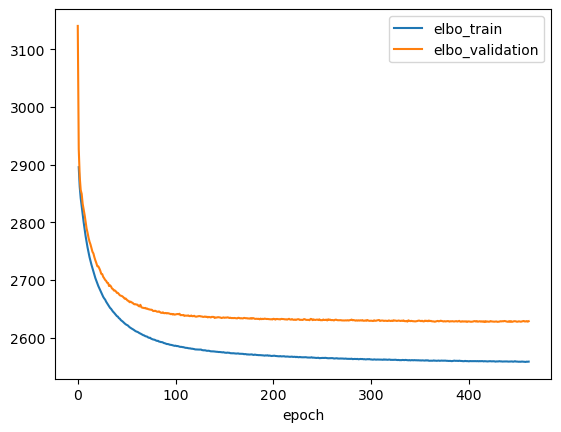

In [8]:
ax = vae.history['elbo_train'][1:].plot()
vae.history['elbo_validation'].plot(ax=ax)

In [9]:
data.obs["celltype_scanvi"] = 'Unknown'
ref_idx = data.obs['batch'] == "reference"
data.obs["celltype_scanvi"][ref_idx] = data.obs['cell_type'][ref_idx]

In [10]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=data,
    labels_key="celltype_scanvi",
    unlabeled_category="Unknown",
)

In [11]:
lvae.train(max_epochs=1000, n_samples_per_label=100)

INFO     Training for 1000 epochs.                                                                                 


INFO: GPU available: False, used: False
2023-09-10 14:01:15 - INFO - GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
2023-09-10 14:01:15 - INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2023-09-10 14:01:15 - INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2023-09-10 14:01:15 - INFO - HPU available: False, using: 0 HPUs


Epoch 1000/1000: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [51:09<00:00,  3.07s/it, v_num=1, train_loss_step=2.67e+3, train_loss_epoch=2.63e+3]

INFO: `Trainer.fit` stopped: `max_epochs=1000` reached.
2023-09-10 14:52:25 - INFO - `Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [51:09<00:00,  3.07s/it, v_num=1, train_loss_step=2.67e+3, train_loss_epoch=2.63e+3]


<AxesSubplot: xlabel='epoch'>

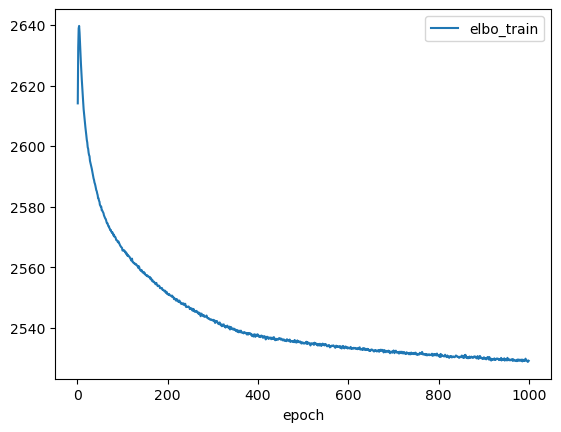

In [12]:
lvae.history['elbo_train'][1:].plot()

We now can perform the label transfer/prediction and obtain the joint embedding of reference and query data.

In [13]:
data.obs["C_scANVI"] = lvae.predict(data)
data.obsm["X_scANVI"] = lvae.get_latent_representation(data)

In [14]:
sc.pp.neighbors(data, use_rep="X_scANVI")
sc.tl.umap(data)

... storing 'celltype_scanvi' as categorical
... storing 'C_scANVI' as categorical


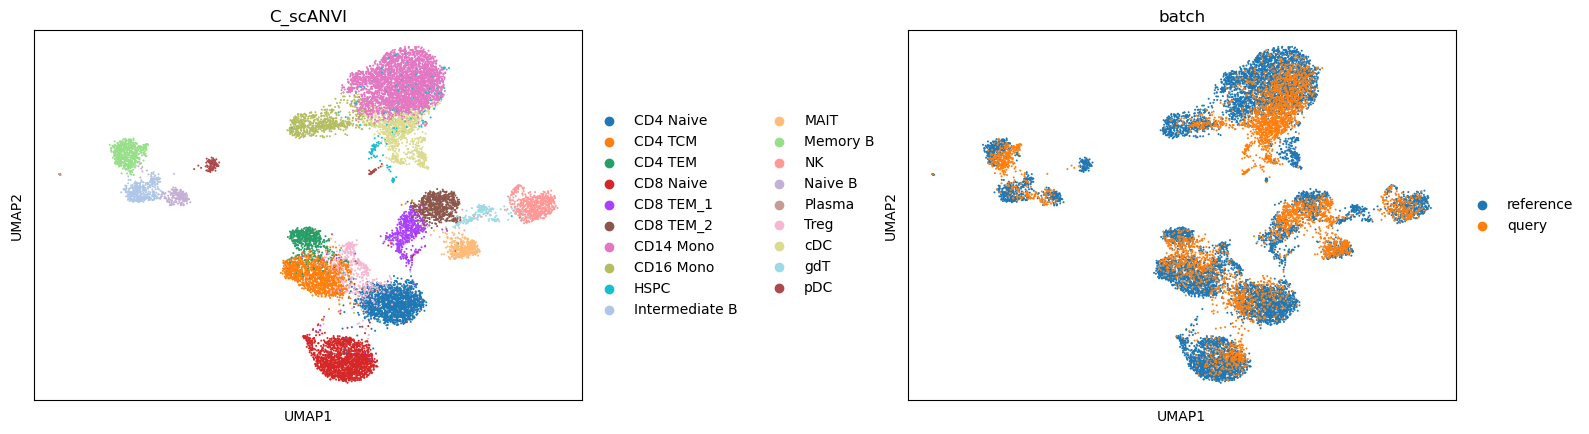

In [15]:
sc.pl.umap(data, color=['C_scANVI', "batch"], wspace=0.45)

Save the predicted cell type labels back to the original cell by bin matrix.

In [16]:
atac.obs['cell_type'] = data.obs.loc[atac.obs_names + '_query']['C_scANVI'].to_numpy()

We can see that the predicted cell type labels are pretty consistent with the leiden cluster labels. Since our ATAC-seq data has fewer cells, we do not have the power to separate CD8 T and CD4 T cells, as well as a few other subtypes.

... storing 'cell_type' as categorical


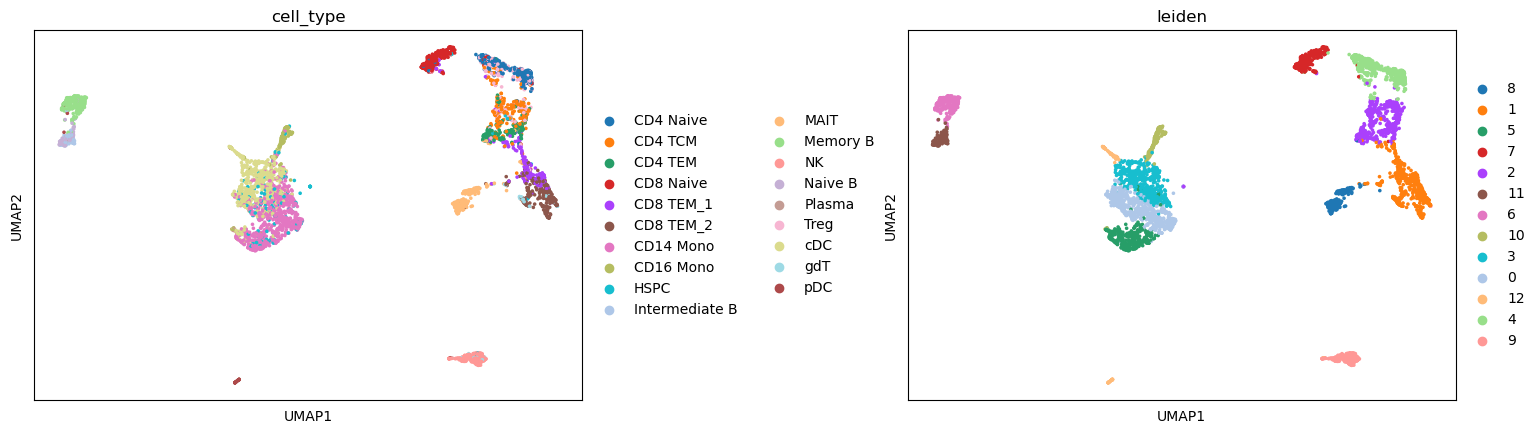

In [17]:
sc.pl.umap(atac, color=['cell_type', "leiden"], wspace=0.45)

Now let's save the annotated AnnData object for future use.

In [18]:
atac.write("pbmc5k_annotated.h5ad", compression="gzip")

## What's next?

- [Differential peak analysis](https://kzhang.org/SnapATAC2/tutorials/diff.html)